In [1]:
import pickle, os, sys
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')
plt.rc('font', size=12)

In [2]:
with open('1_mmrf_dataset_type.pkl','rb') as f:
    dataset = pickle.load(f)
with open('1_mmrf_dataset_2mos_type.pkl','rb') as f:
    dataset_2mos = pickle.load(f)
print (dataset.keys())
print(dataset['baseline'].keys())
print (dataset_2mos.keys())
print(dataset_2mos['baseline'].keys())

dict_keys(['treatment', 'labs', 'baseline', 'outcomes', 'trt_outcomes'])
dict_keys(['pids', 'data', 'obs', 'names'])
dict_keys(['treatment', 'labs', 'baseline', 'outcomes', 'trt_outcomes'])
dict_keys(['pids', 'data', 'obs', 'names'])


In [3]:
from process_tensors import clean_baseline, clean_labs, get_splits

### Step 1: Restrict all data to share a global ordering over patient ids (from outcomes)
* Plot distribution over outcomes

In [4]:
new_dset = {}
outcomes_type = 'trt_resp' # or 'mortality'

if outcomes_type == 'mortality': 
    new_dset['patient_ids'] = dataset['outcomes']['pids']
    new_dset['y_data']   = dataset['outcomes']['data']
    new_dset['event_obs']= dataset['outcomes']['obs']
elif outcomes_type == 'trt_resp':
    new_dset['patient_ids'] = dataset['trt_outcomes']['pids']
    new_dset['y_data']      = dataset['trt_outcomes']['data']
    new_dset['event_obs']   = dataset['trt_outcomes']['obs']
    new_dset['tr_names']    = dataset['trt_outcomes']['names']
    
pts = new_dset['patient_ids'].tolist()
for k in ['treatment','labs','baseline']:
    pts_src = dataset[k]['pids'].tolist()
    idx_map = np.array([pts_src.index(v) for v in pts])
    new_dset[k+'_data'] = dataset[k]['data'][idx_map]
    new_dset[k+'_m']    = dataset[k]['obs'][idx_map]
    new_dset[k+'_names']= dataset[k]['names']
    
new_dset_2mos = {}

if outcomes_type == 'mortality':     
    new_dset_2mos['patient_ids'] = dataset_2mos['outcomes']['pids']
    new_dset_2mos['y_data']      = dataset_2mos['outcomes']['data']
    new_dset_2mos['event_obs']   = dataset_2mos['outcomes']['obs']
elif outcomes_type == 'trt_resp': 
    new_dset_2mos['patient_ids'] = dataset_2mos['trt_outcomes']['pids']
    new_dset_2mos['y_data']      = dataset_2mos['trt_outcomes']['data']
    new_dset_2mos['event_obs']   = dataset_2mos['trt_outcomes']['obs']
    new_dset_2mos['tr_names']    = dataset_2mos['trt_outcomes']['names']
    new_dset_2mos['ym_data']     = dataset_2mos['outcomes']['data']
    new_dset_2mos['ce']     = dataset_2mos['outcomes']['obs']

pts = new_dset_2mos['patient_ids'].tolist()
for k in ['treatment','labs','baseline']:
    pts_src = dataset_2mos[k]['pids'].tolist()
    idx_map = np.array([pts_src.index(v) for v in pts])
    new_dset_2mos[k+'_data'] = dataset_2mos[k]['data'][idx_map]
    new_dset_2mos[k+'_m']    = dataset_2mos[k]['obs'][idx_map]
    new_dset_2mos[k+'_names']= dataset_2mos[k]['names']

In [5]:
print(f'shape of treatment data: {new_dset_2mos["treatment_data"].shape}')
print(f'shape of lab data: {new_dset_2mos["labs_data"].shape}')
print(f'shape of baseline data: {new_dset_2mos["baseline_data"].shape}')

shape of treatment data: (1074, 33, 6)
shape of lab data: (1074, 33, 16)
shape of baseline data: (1074, 16)


### Step 2: Visualize outcome values after scaling

72


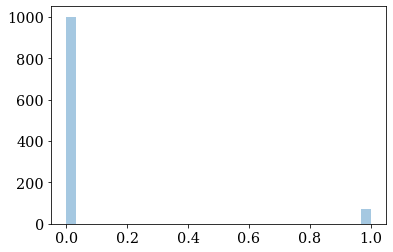

In [8]:
if outcomes_type == 'mortality':
    fig, axlist = plt.subplots(1,1)
    sns.distplot(new_dset['y_data'][new_dset['event_obs']==1],label='observed', ax = axlist, kde=False)
    sns.distplot(new_dset['y_data'][new_dset['event_obs']==0],label='censored', ax = axlist, kde=False)
    axlist.legend(fontsize=18)
    axlist.set_xlim([0,70])
elif outcomes_type == 'trt_resp': 
    fig, axlist = plt.subplots(1,1)
    sns.distplot(new_dset['y_data'], ax = axlist, kde=False)
    print(len(np.where(new_dset['y_data']==1.)[0]))

[0 0 1 ... 0 0 0]


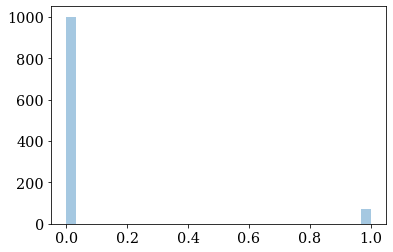

In [9]:
if outcomes_type == 'mortality':
    fig, axlist = plt.subplots(1,1)
    sns.distplot(new_dset_2mos['y_data'][new_dset_2mos['event_obs']==1],label='observed', ax = axlist, kde=False)
    sns.distplot(new_dset_2mos['y_data'][new_dset_2mos['event_obs']==0],label='censored', ax = axlist, kde=False)
    axlist.legend(fontsize=18)
    axlist.set_xlim([0,70])
elif outcomes_type == 'trt_resp': 
    fig, axlist = plt.subplots(1,1)
    sns.distplot(new_dset_2mos['y_data'], ax = axlist, kde=False)
    print(new_dset_2mos['y_data'])

### Step 2: Clean baseline values (to be in a range -7 to 7ish where 0 corresponds to reference [max])

In [10]:
# Reference values for lab measurements
# min/max/scale (calculated by attempting to ensure that max labs lie b/w 5-8)
healthy_mins_max = {
    'cbc_abs_neut':(2., 7.5,1/3.), # abs neutrophil count (3.67, 1.), (2.83, 4.51)
    'chem_albumin':(34, 50,1/8.), # chemical albumin (43.62, 2.77), (41.30, 45.94)
    'chem_bun':(2.5, 7.1,1/5.), #BUN # reference range, (4.8, 1.15)
    'chem_calcium':(2.2, 2.7,2.), #Calcium, (2.45, 0.125)
    'chem_creatinine':(66, 112,1/36.), # creatinine, (83., 24.85), (62.22, 103.77)
    'chem_glucose':(3.9, 6.9,1/5.), # glucose, (4.91, 0.40), (4.58, 5.24)
    'cbc_hemoglobin':(13., 17.,1), # hemoglobin (12.90, 15.64), (8.86, 1.02)
    'chem_ldh':(2.33, 4.67,1/3.), #LDH, (3.5, 0.585)
    'serum_m_protein':(0.1, 1.1, 1), # M protein (<3 g/dL is MGUS, any presence of protein is pathological); am just using the data mean/std for this, (0.85, 1.89)
    'urine_24hr_m_protein':(0.0, 0.1, 1), # Urine M protein 
    'cbc_platelet':(150, 400,1/60.), # platelet count (206.42, 334.57), (270.5, 76.63)
    'chem_totprot':(6, 8,1/6.), # total protein, (7, 0.5)
    'urine_24hr_total_protein':(0, 0.23, 1), # 
    'cbc_wbc':(3, 10,1/4.), # WBC  (5.71, 8.44), (7.07, 1.63)
    'serum_iga':(0.85, 4.99, 1.), # IgA, (2.92, 1.035)
    'serum_igg':(6.10, 16.16,1/10.), # IgG, (11.13, 2.515)
    'serum_igm':(0.35, 2.42,1), #IgM, (1.385, 0.518)
    'serum_lambda':(0.57, 2.63, 1/2.), #serum lambda, (1.6, 0.515)
    'serum_kappa':(.33, 1.94,1/8.), #serum kappa , (1.135, 0.403)
    'serum_beta2_microglobulin':(0.7, 1.80, 1/3.), #serum_beta2_microglobulin,
    'serum_c_reactive_protein':(0.0, 1., 1.) #serum_c_reactive_protein,
}

In [11]:
clean_baseline(new_dset, healthy_mins_max)

A] Before cleaning
idx, featurename, min, mean, max
0 iss 1.0 1.8535948506193909 3.0
1 age 27.0 62.78398510242086 93.0
2 gender 1.0 1.3957169459962757 2.0
3 ecog 0.0 0.8508874120751558 4.0
4 serum_beta2_microglobulin 0.1 4.785896264800075 22.400000000000002
5 PC1 -30.66659494 0.06284026573910537 140.0614706
6 PC2 -40.46897077 -0.4435453236004378 115.7871011
7 PC3 -57.38038138 -0.08536470651579149 51.23220332
8 PC4 -36.28005205 -0.3556388830277744 51.01689348
9 PC5 -37.58013775 -0.10985991816343105 50.21645239
10 heavy_chain False 0.8370577281191807 True
11 igg_type False 0.6396648044692738 True
12 iga_type False 0.1452513966480447 True
13 igm_type False 0.0521415270018622 True
14 kappa_type False 0.6517690875232774 True
15 lambda_type False 0.30074487895716945 True
------
------
C] After cleaning
0 iss 1.0 1.8535948 3.0 False
1 age -3.405822 0.0 2.8758779 False
2 gender -1.0 -0.20856611 1.0 False
3 ecog -0.061402757 -6.0603604e-08 0.22724976 False
4 serum_beta2_microglobulin -0.338149 

In [12]:
clean_baseline(new_dset_2mos, healthy_mins_max)

A] Before cleaning
idx, featurename, min, mean, max
0 iss 1.0 1.8535948506193909 3.0
1 age 27.0 62.78398510242086 93.0
2 gender 1.0 1.3957169459962757 2.0
3 ecog 0.0 0.8508874120751558 4.0
4 serum_beta2_microglobulin 0.1 4.785896264800075 22.400000000000002
5 PC1 -30.66659494 0.06284026573910537 140.0614706
6 PC2 -40.46897077 -0.4435453236004378 115.7871011
7 PC3 -57.38038138 -0.08536470651579149 51.23220332
8 PC4 -36.28005205 -0.3556388830277744 51.01689348
9 PC5 -37.58013775 -0.10985991816343105 50.21645239
10 heavy_chain False 0.8370577281191807 True
11 igg_type False 0.6396648044692738 True
12 iga_type False 0.1452513966480447 True
13 igm_type False 0.0521415270018622 True
14 kappa_type False 0.6517690875232774 True
15 lambda_type False 0.30074487895716945 True
------
------
C] After cleaning
0 iss 1.0 1.8535948 3.0 False
1 age -3.405822 0.0 2.8758779 False
2 gender -1.0 -0.20856611 1.0 False
3 ecog -0.061402757 -6.0603604e-08 0.22724976 False
4 serum_beta2_microglobulin -0.338149 

### Step 3: Clean time-series lab values

In [13]:
clean_labs(new_dset, healthy_mins_max)
clean_labs(new_dset_2mos, healthy_mins_max)

A] Before cleaning
idx, featurename, min, mean, max
0 cbc_abs_neut 0.0 0.519731427634571 19.5
1 chem_albumin 0.0 5.862420689567351 140.0
2 chem_bun 0.0 0.9741879421783552 33.56
3 chem_calcium 0.0 0.3528982698384464 4.25
4 chem_creatinine 0.0 15.278424980316561 429.31999999999994
5 chem_glucose 0.0 0.9435098572032145 32.775
6 cbc_hemoglobin 0.0 1.1785143925188335 11.655999999999999
7 serum_kappa -9.9 0.5952868892903069 14.66
8 serum_m_protein 0.0 0.10167164650470767 5.6499999999999995
9 cbc_platelet 0.0 29.71177957924597 732.0
10 chem_totprot 0.0 1.057953841575954 17.1
11 cbc_wbc 0.0 0.8608215804751658 29.5
12 serum_iga 0.0 0.19202532087370253 9.0
13 serum_igg 0.0 1.5864588041698935 49.050000000000004
14 serum_igm -0.16 0.04873071272599691 6.4
15 serum_lambda 0.0 0.3598355664203684 11.35
------
B] Subtracting healthy max  7.5  from cbc_abs_neut  and scaling:  0.3333333333333333
B] Subtracting healthy max  50  from chem_albumin  and scaling:  0.125
B] Subtracting healthy max  7.1  from c

### Step 4: Get censorship balanced train/test splits

In [14]:
train_valid_folds, testidx = get_splits(new_dset['y_data'], nfolds=5)

Total:  1074
Total:  751
Fold:  0 525 226
Event obs:  35 15
Total:  751
Fold:  1 525 226
Event obs:  35 15
Total:  751
Fold:  2 525 226
Event obs:  35 15
Total:  751
Fold:  3 525 226
Event obs:  35 15
Total:  751
Fold:  4 525 226
Event obs:  35 15


In [11]:
if not os.path.exists('folds.pkl'):
    train_valid_folds, testidx = get_splits(new_dset['event_obs'], nfolds = 5)
    with open('folds.pkl','wb') as f:
        pickle.dump((train_valid_folds, testidx),f)
else:
    print ('Reading...')
    with open('folds.pkl','rb') as f:
        train_valid_folds, testidx = pickle.load(f)

Reading...


### Step 5: Split dataset for 5 fold CV

In [12]:
for fold in range(5):
    print ('Saving fold ', fold)
    final_dataset = {}
    final_dataset[fold] = {}
    for tvt in ['train','valid','test']:
        if  tvt =='test':
            idx = testidx
        elif tvt =='train':
            idx = train_valid_folds[fold][0]
        elif tvt == 'valid':
            idx = train_valid_folds[fold][1]
        else:
            raise NotImplemented()
        final_dataset[fold][tvt] = {}
        final_dataset[fold][tvt]['pids']   = new_dset['patient_ids'][idx]
        # labs
        final_dataset[fold][tvt]['x']      = new_dset['labs_data_clean'][idx]
        final_dataset[fold][tvt]['m']    = new_dset['labs_m'][idx]
        final_dataset[fold][tvt]['feature_names_x']    = new_dset['labs_names']
        # outcomes
        final_dataset[fold][tvt]['ys_seq'] = new_dset['y_data'][idx].reshape(-1,1)
        final_dataset[fold][tvt]['ce']     = (1.-new_dset['event_obs'][idx]).reshape(-1,1)
        # baseline
        final_dataset[fold][tvt]['b']      = new_dset['baseline_data_clean'][idx]
        final_dataset[fold][tvt]['feature_names']    = new_dset['baseline_names']
        # treatments
        final_dataset[fold][tvt]['a']      = new_dset['treatment_data'][idx]
        final_dataset[fold][tvt]['m_a']    = new_dset['treatment_m'][idx]
        final_dataset[fold][tvt]['feature_names_a']    = new_dset['treatment_names']
    
    # Forward fill missing data in longitudinal lab tensors
    for tvt in ['train','valid','test']:
        x_new  = np.copy(final_dataset[fold][tvt]['x'])
        x_new[final_dataset[fold][tvt]['m']==0] = np.nan
        x_new_filled  = []
        for k in range(x_new.shape[-1]):
            x_new_filled.append(pd.DataFrame(x_new[...,k]).fillna(method='ffill', axis=1).values[...,None])
        x_new_filled  = np.concatenate(x_new_filled, axis=-1)
        assert not np.any(np.isnan(x_new_filled)),'should not be any nans'
        final_dataset[fold][tvt]['x'] = x_new_filled
    
    # Restrict (in train/valid set) to patients with atleast two longitudinal observations
    T_lb = 2
    for tvt in ['train']:
        M     = final_dataset[fold][tvt]['m']
        M_t   = (M.sum(-1)>1.)*1.
        all_t = M_t.sum(-1)
        keep_idx = np.argwhere(all_t>T_lb).ravel()
        if tvt == 'train':
            C = final_dataset[fold][tvt]['ce']
            print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
        for kk in ['a','x','m','ys_seq','ce','b','pids','m_a']:
            final_dataset[fold][tvt][kk] = np.copy(final_dataset[fold][tvt][kk][keep_idx])
        if tvt == 'train':
            C = final_dataset[fold][tvt]['ce']
            print ('After: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])

    with open('cleaned_mm'+str(fold)+'.pkl','wb') as f:
        pickle.dump(final_dataset, f)

Saving fold  0
Before: N censored/total  360.0 489 0.7361963190184049
After: N censored/total  335.0 439 0.7630979498861048
Saving fold  1
Before: N censored/total  364.0 489 0.7443762781186094
After: N censored/total  340.0 441 0.7709750566893424
Saving fold  2
Before: N censored/total  359.0 489 0.7341513292433538
After: N censored/total  336.0 438 0.7671232876712328
Saving fold  3
Before: N censored/total  362.0 489 0.7402862985685071
After: N censored/total  340.0 439 0.7744874715261959
Saving fold  4
Before: N censored/total  362.0 489 0.7402862985685071
After: N censored/total  341.0 439 0.7767653758542141


In [13]:
new_dset_2mos['treatment_data'].shape

(1074, 33, 6)

In [15]:
for fold in range(5):
    print ('Saving fold ', fold)
    final_dataset = {}
    final_dataset[fold] = {}
    for tvt in ['train','valid','test']:
        if  tvt =='test':
            idx = testidx
        elif tvt =='train':
            idx = train_valid_folds[fold][0]
        elif tvt == 'valid':
            idx = train_valid_folds[fold][1]
        else:
            raise NotImplemented()
        final_dataset[fold][tvt] = {}
        final_dataset[fold][tvt]['pids']               = new_dset_2mos['patient_ids'][idx]
        # labs
        final_dataset[fold][tvt]['x']                  = new_dset_2mos['labs_data_clean'][idx]
        final_dataset[fold][tvt]['m']                  = new_dset_2mos['labs_m'][idx]
        final_dataset[fold][tvt]['feature_names_x']    = new_dset_2mos['labs_names']
        # outcomes
        final_dataset[fold][tvt]['ys_seq'] = new_dset_2mos['y_data'][idx].reshape(-1,1)
        final_dataset[fold][tvt]['ce']     = (1.-new_dset_2mos['event_obs'][idx]).reshape(-1,1)
        if outcomes_type == 'trt_resp': 
            final_dataset[fold][tvt]['feature_names_y']    = new_dset_2mos['tr_names']
        # baseline
        final_dataset[fold][tvt]['b']      = new_dset_2mos['baseline_data_clean'][idx]
        final_dataset[fold][tvt]['feature_names']    = new_dset_2mos['baseline_names']
        # treatments
        final_dataset[fold][tvt]['a']      = new_dset_2mos['treatment_data'][idx]
        final_dataset[fold][tvt]['m_a']    = new_dset_2mos['treatment_m'][idx]
        final_dataset[fold][tvt]['feature_names_a']    = new_dset_2mos['treatment_names']
    
    # Forward fill missing data in longitudinal lab tensors
    for tvt in ['train','valid','test']:
        x_new  = np.copy(final_dataset[fold][tvt]['x'])
        x_new[final_dataset[fold][tvt]['m']==0] = np.nan
        x_new_filled  = []
        for k in range(x_new.shape[-1]):
            x_new_filled.append(pd.DataFrame(x_new[...,k]).fillna(method='ffill', axis=1).values[...,None])
        x_new_filled  = np.concatenate(x_new_filled, axis=-1)
        assert not np.any(np.isnan(x_new_filled)),'should not be any nans'
        final_dataset[fold][tvt]['x'] = x_new_filled
    
    # Restrict (in train/valid set) to patients with atleast two longitudinal observations
    T_lb = 2
    print(f'train...')
    for tvt in ['train']:
        M     = final_dataset[fold][tvt]['m']
        M_t   = (M.sum(-1)>1.)*1.
        all_t = M_t.sum(-1)
        keep_idx = np.argwhere(all_t>T_lb).ravel()
        if tvt == 'train':
            if outcomes_type == 'mortality':
                C = final_dataset[fold][tvt]['ce']
                print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
            elif outcomes_type == 'trt_resp': 
                Y = final_dataset[fold][tvt]['ys_seq']
                C = final_dataset[fold][tvt]['ce']
                print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
                for i in range(np.max(Y)+1): 
                    print (f'Before: Y class {i}, N: {len(np.where(Y == i)[0])}')
        for kk in ['a','x','m','ys_seq','ce','b','pids','m_a']:
            final_dataset[fold][tvt][kk] = np.copy(final_dataset[fold][tvt][kk][keep_idx])
        if tvt == 'train':
            if outcomes_type == 'mortality':
                C = final_dataset[fold][tvt]['ce']
                print ('After: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
            elif outcomes_type == 'trt_resp': 
                Y = final_dataset[fold][tvt]['ys_seq']
                C = final_dataset[fold][tvt]['ce']
                print ('After: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
                for i in range(np.max(Y)+1): 
                    print (f'After: Y class {i}, N: {len(np.where(Y == i)[0])}')
    print (final_dataset[fold]['train']['x'].shape)
    for tvt in ['valid', 'test']: 
        print(f'{tvt}...')
        if outcomes_type == 'mortality':
            C = final_dataset[fold][tvt]['ce']
            print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
        elif outcomes_type == 'trt_resp': 
            Y = final_dataset[fold][tvt]['ys_seq']
            C = final_dataset[fold][tvt]['ce']
            print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
        for i in range(np.max(Y)+1): 
            print (f'Before: Y class {i}, N: {len(np.where(Y == i)[0])}')
    print()
    with open('cleaned_mm'+str(fold)+'_2mos_tr.pkl','wb') as f:
        pickle.dump(final_dataset, f)

Saving fold  0
train...
Before: N censored/total  0.0 525 0.0
Before: Y class 0, N: 490
Before: Y class 1, N: 35
After: N censored/total  0.0 428 0.0
After: Y class 0, N: 399
After: Y class 1, N: 29
(428, 33, 16)
valid...
Before: N censored/total  0.0 226 0.0
Before: Y class 0, N: 211
Before: Y class 1, N: 15
test...
Before: N censored/total  0.0 323 0.0
Before: Y class 0, N: 301
Before: Y class 1, N: 22

Saving fold  1
train...
Before: N censored/total  0.0 525 0.0
Before: Y class 0, N: 490
Before: Y class 1, N: 35
After: N censored/total  0.0 428 0.0
After: Y class 0, N: 398
After: Y class 1, N: 30
(428, 33, 16)
valid...
Before: N censored/total  0.0 226 0.0
Before: Y class 0, N: 211
Before: Y class 1, N: 15
test...
Before: N censored/total  0.0 323 0.0
Before: Y class 0, N: 301
Before: Y class 1, N: 22

Saving fold  2
train...
Before: N censored/total  0.0 525 0.0
Before: Y class 0, N: 490
Before: Y class 1, N: 35
After: N censored/total  0.0 438 0.0
After: Y class 0, N: 410
After: 